In [1]:
import json
import numpy as np
import cs_vqe.circuit as cs_circ
import utils.plotting_tools as plot
import utils.qonversion_tools as qonvert
import utils.linalg_tools as la
import utils.bit_tools as bit
import utils.cs_vqe_tools_original as cs_tools
from qat.lang.AQASM import Program, X, H, S, CNOT, RZ
from qat.core.variables import Variable
from qat.core import Observable, Term
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from qat.plugins import ScipyMinimizePlugin
from qat.qpus import Stabs, LinAlg, MPS, Feynman, NoisyQProc
import random

Will store matrices in dense form
Qiskit Nature not installed


In [2]:
with open('data/model_data.json', 'r') as json_file:
    model_data = json.load(json_file)

for mol in model_data.keys():
    print(mol, model_data[mol]['chem_acc_num_q'])
    for name, a in model_data[mol]['ansatze'].items():
        print('-', name, len(a))

H2O_STO-3G_SINGLET 7
- uccsd 228
- excite3 84
- excite4 168
- excite5 184
LiH_STO-3G_SINGLET 4
- uccsd 112
- excite3 36
- excite4 44
- excite5 56
HF_STO-3G_SINGLET 4
- uccsd 44
- excite3 8
- excite4 44
- excite5 44
CH2_STO-3G_SINGLET 8
- uccsd 220
- excite3 26
- excite4 208
- excite5 344
BeH2_STO-3G_SINGLET 7
- uccsd 176
- excite3 60
- excite4 72
- excite5 92
Be_STO-3G_SINGLET 3
- uccsd 24
- excite3 12
- excite4 12
- excite5 36
C_STO-3G_SINGLET 4
- uccsd 8
- excite3 30
- excite4 46
- excite5 46
NH_STO-3G_SINGLET 6
- uccsd 36
- excite3 16
- excite4 128
- excite5 152
BH_STO-3G_SINGLET 6
- uccsd 60
- excite3 64
- excite4 72
- excite5 72
B+_STO-3G_SINGLET 3
- uccsd 16


In [3]:
speciesname = "C_STO-3G_SINGLET"
mol_model    = model_data[speciesname]
anz_op = mol_model['ansatze']['uccsd']
mol_circ = cs_circ.cs_vqe_circuit(model_data=mol_model)
num_sim_q = mol_circ.chem_acc_num_q
print('Number of terms in the ansatz:', len(anz_op))
print('%s reaches chemical accuracy for %i-qubit CS-VQE' % (speciesname, num_sim_q))

Number of terms in the ansatz: 8
C_STO-3G_SINGLET reaches chemical accuracy for 4-qubit CS-VQE


In [4]:
def plot_qlm_result(result):
    nfev = len(eval(result.meta_data['optimization_trace']))
    energy=eval(result.meta_data['optimization_trace'])

    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot([np.log10(abs(e-mol_circ.truegs)) for e in energy], label='CS-VQE convergence', color = "black")
    ax.hlines(np.log10(abs(result.value-mol_circ.truegs)), 0, nfev, color='black', label='Convergence value', ls='--')
    ax.hlines(np.log10(0.0016), 0, nfev, color='green', label='Chemical accuracy', ls='--')
    ax.hlines(np.log10(mol_circ.HF_energy-mol_circ.truegs), 0, nfev, color='red', label='Hartree-Fock energy', ls='--')
    ax.hlines(np.log10(mol_circ.noncon-mol_circ.truegs), 0, nfev, color='orange', label='Noncontextual ground state energy', ls='--')

    ax.set_title('{}: {}-qubit CS-VQE simulation'.format(speciesname, num_sim_q))
    ax.set_xlabel("Optimization count")
    ax.set_ylabel("Logarithmic error [log(Ha)]")
    ax.legend()
    
    return fig

In [5]:
class QLM_circuit():
    """Class for building and executing QLM circuits
    """
    gate_dict = {'X':X,'H':H,'S':S,'SDG':S.dag(),'RZ':RZ,'CX':CNOT}
    
    def __init__(self,
                 n_qubits,
                 qpu_type   = NoisyQProc(sim_method="stochastic",
                                         n_samples=10000),
                 opt_method = 'COBYLA',
                 maxiter    = 1000,
                 theta0     = None
                 ):
        
        optimizer=ScipyMinimizePlugin(method=opt_method,
                                    tol=1e-5,
                                    options={"maxiter": maxiter},
                                    x0=theta0)
        self.qpu = optimizer | qpu_type
        self.n_qubits = n_qubits
        
        
    def construct_hamiltonian(self, ham_dict):
        assert(len(list(ham_dict.keys())[0])==self.n_qubits)
        pauli_terms = [Term(coeff, op, list(range(self.n_qubits))) for op, coeff in ham_dict.items()]
        hamiltonian = Observable(self.n_qubits,pauli_terms=pauli_terms)
        return hamiltonian
        
        
    def build_qlm_circuit(self, instructions):
        for i in instructions[::-1]:
            if i[1]!=[]:
                num_params = i[1][0] + 1
                break

        prog = Program()
        qbits_reg = prog.qalloc(self.n_qubits)
        params = [prog.new_var(float, "\\P{}".format(i)) for i in range(num_params)]

        for gate, var_num, q_pos in instructions:
            q_pos = [self.n_qubits-p-1 for p in q_pos] #qubit ordering is reversed compared with Qiskit
            if gate == 'RZ':
                prog.apply(RZ(params[var_num[0]]), qbits_reg[q_pos[0]])
            elif gate == 'CX':
                prog.apply(CNOT, qbits_reg[q_pos[0]], qbits_reg[q_pos[1]])
            else:
                prog.apply(self.gate_dict[gate], qbits_reg[q_pos[0]])

        qc = prog.to_circ()

        return qc
    
    
    def run_vqe(self, ham_dict, instructions, shots=1024):
        
        hamiltonian = self.construct_hamiltonian(ham_dict)
        qc = self.build_qlm_circuit(instructions)
        job = qc.to_job(job_type="OBS", nbshots=shots, observable=hamiltonian)
        result = self.qpu.submit(job)
        
        return result

In [ ]:
shot_data={}
ham_dict, num_sim_q, num_params, instructions = mol_circ.qlm_circuit(anz_op, num_sim_q).values()
qlm_circ = QLM_circuit(num_sim_q, opt_method='COBYLA', maxiter=1000, theta0=mol_circ.init_param)
for n in range(12):
    shots=2**n
    result = qlm_circ.run_vqe(ham_dict, instructions, shots=shots)
    shot_data[str(shots)] = result
    print(shots, result.value-mol_circ.truegs)
#fig = plot_qlm_result(result)

1 0.02034098690553776
2 0.02034098690553776


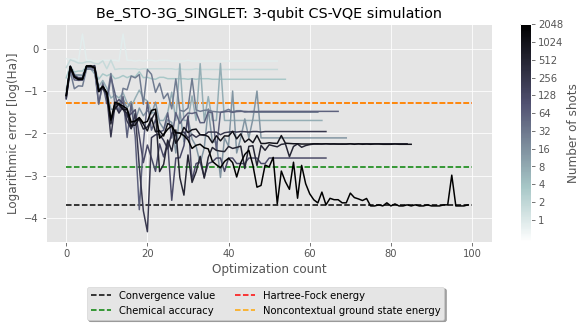

In [8]:
fig, ax = plt.subplots(figsize=(10,4))
keys = list(shot_data.keys())
increments=np.linspace(0.1,1,len(keys))
longest_nfev=0

for index, k in enumerate(keys):
    nfev = len(eval(shot_data[k].meta_data['optimization_trace']))
    if nfev > longest_nfev:
        longest_nfev = nfev
    energy=eval(shot_data[k].meta_data['optimization_trace'])
    ax.plot([np.log10(abs(e-mol_circ.truegs)) for e in energy], 
             color = plt.cm.bone(1-(index+1)/len(shot_data)))

ax.hlines(np.log10(abs(shot_data['2048'].value-mol_circ.truegs)), 0, longest_nfev, color='black', label='Convergence value', ls='--')
ax.hlines(np.log10(0.0016), 0, longest_nfev, color='green', label='Chemical accuracy', ls='--')
ax.hlines(np.log10(mol_circ.HF_energy-mol_circ.truegs), 0, longest_nfev, color='red', label='Hartree-Fock energy', ls='--')
ax.hlines(np.log10(mol_circ.noncon-mol_circ.truegs), 0, longest_nfev, color='orange', label='Noncontextual ground state energy', ls='--')

ax.set_title('{}: {}-qubit CS-VQE simulation'.format(speciesname, num_sim_q))
ax.set_xlabel("Optimization count")
ax.set_ylabel("Logarithmic error [log(Ha)]")

cbar = fig.colorbar(cm.ScalarMappable(norm=Normalize(), cmap='bone_r'), 
                     ax=ax, label='Number of shots', ticks=increments)
cbar.ax.set_yticklabels(keys)
fig.legend(loc="lower center",   # Position of legend
            borderaxespad=0.1,    # Small spacing around legend box
            ncol=2,
            bbox_to_anchor=(0.43, -0.15),
            fancybox=True, 
            shadow=True)

In [9]:
file = speciesname+'_CS-VQE_shot_variation'

fig.savefig('plots/'+file+'.png', dpi=300, bbox_inches='tight')

data={}
for k in result.meta_data.keys():
    data[str(k)] = result.meta_data[k]
    
with open("data/QLM_circuits/"+file+".json", "w") as outfile: 
    json.dump(data, outfile)